[1/5] ➜ 讀取資料中...
[2/5] ➜ 建立圖並標記環...


⛏️ 檢查 DAG 結構: 9504852it [00:08, 1131719.06it/s]



[2/5] ➜ 計算邊風險中...


📊 風險評估: 9504852it [00:34, 277094.30it/s]



[3/5] ➜ 使用固定門檻 1.50 執行 TD-UF 聚合...


⚙️ TD-UF 遍歷中: 100%|██████████████████████████████████| 855460/855460 [00:01<00:00, 783493.13it/s]


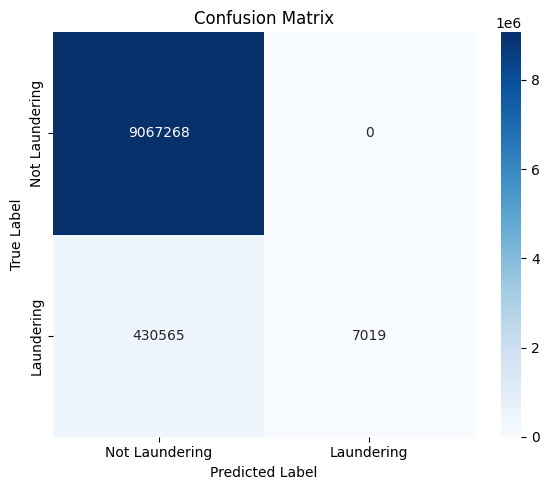


[4/5] === TD-UF 評估結果 ===
+-----------+---------+
| Metric    |   Score |
+===========+=========+
| Precision |   1     |
+-----------+---------+
| Recall    |   0.016 |
+-----------+---------+
| F1 Score  |   0.032 |
+-----------+---------+

[5/5] ➜ Monte Carlo 擴散模擬中...


📈 群體擴散模擬: 100%|███████████████████████████████████| 850971/850971 [00:41<00:00, 20614.08it/s]



⏱️ 總計算時間：162.85 秒


In [1]:
import polars as pl
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from collections import defaultdict, deque
import random
import time


# === 自建 DAG 結構並移除形成環的邊 === #
def enforce_dag_and_mark(df):
    graph = defaultdict(list)
    in_degree = defaultdict(int)
    removed_edges = set()
    seen_edges = set()
    for u, v in tqdm(df.select(["Sender_account", "Receiver_account"]).iter_rows(), desc="⛏️ 檢查 DAG 結構", ncols=100):
        if (u, v) in seen_edges:
            continue
        seen_edges.add((u, v))
        graph[u].append(v)
        in_degree[v] += 1
        queue, visited = deque([v]), set()
        found_cycle = False
        while queue:
            cur = queue.popleft()
            if cur == u:
                found_cycle = True
                break
            for nei in graph.get(cur, []):
                if nei not in visited:
                    visited.add(nei)
                    queue.append(nei)
        if found_cycle:
            graph[u].pop()
            in_degree[v] -= 1
            removed_edges.add((u, v))
    df = df.with_columns([
        (pl.struct(["Sender_account", "Receiver_account"])
         .map_elements(lambda x: int((x["Sender_account"], x["Receiver_account"]) in removed_edges), return_dtype=pl.Int8)
         .alias("CycleFlag"))
    ])
    df = df.with_columns([
        (pl.col("Is_laundering") | pl.col("CycleFlag")).cast(pl.Int8).alias("Is_laundering")
    ])
    return graph, in_degree, df

# === Topological sort (Kahn algorithm)=== #
def topological_sort(graph, in_degree):
    order = []
    zero_in = deque([u for u in graph if in_degree[u] == 0])
    while zero_in:
        u = zero_in.popleft()
        order.append(u)
        for v in graph[u]:
            in_degree[v] -= 1
            if in_degree[v] == 0:
                zero_in.append(v)
    return order

# === TD-UF 合併高風險邊 === #
def td_uf(graph, topo_order, threshold, risk_dict):
    parent = {}
    def find(x):
        if parent.get(x, x) != x:
            parent[x] = find(parent[x])
        return parent.get(x, x)
    def union(x, y):
        px, py = find(x), find(y)
        if px != py:
            parent[py] = px
    for u in tqdm(topo_order, desc="⚙️ TD-UF 遍歷中", ncols=100):
        for v in graph.get(u, []):
            risk = risk_dict.get((u, v), 0)
            if risk >= threshold:
                union(u, v)
    return parent

# === 邊風險計算 === #
def compute_edge_risk(df):
    print("\n[2/5] ➜ 計算邊風險中...")
    risk_dict = {}
    for row in tqdm(df.iter_rows(named=True), desc="📊 風險評估", ncols=100):
        risk = 0.0
        if row["Is_laundering"] == 1:
            risk += 1.5
        if row["Amount"] > 5000:
            risk += 1.0
        try:
            hour = int(row["Time"])
        except:
            hour = 12
        if hour < 6 or hour > 22:
            risk += 0.5
        risk_dict[(row["Sender_account"], row["Receiver_account"])] = risk
    return risk_dict

# === TD-UF 群組評估 + 混淆矩陣顯示 === #
def evaluate_result(df, parent, plot_conf_matrix=False):
    df_group = df.with_columns([
        pl.struct(["Sender_account"]).map_elements(lambda x: parent.get(x["Sender_account"], x["Sender_account"]), return_dtype=pl.Int64).alias("group_origin"),
        pl.struct(["Receiver_account"]).map_elements(lambda x: parent.get(x["Receiver_account"], x["Receiver_account"]), return_dtype=pl.Int64).alias("group_benef")
    ])
    y_true = df_group["Is_laundering"].to_list()
    y_pred = [(g1 == g2) for g1, g2 in zip(df_group["group_origin"], df_group["group_benef"])]
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    if plot_conf_matrix:
        cm = confusion_matrix(y_true, y_pred)
        labels = ["Not Laundering", "Laundering"]
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    return precision, recall, f1

# === 群體內 Monte Carlo 擴散模擬（限圖數） === #
def monte_carlo_within_groups(graph, df, parent, num_simulations=100, walk_length=4, max_groups_to_plot=3):
    print("\n[5/5] ➜ Monte Carlo 擴散模擬中...")
    account_to_group = {acc: parent.get(acc, acc) for acc in set(df["Sender_account"].to_list() + df["Receiver_account"].to_list())}
    group_members = defaultdict(set)
    for acc, g in account_to_group.items():
        group_members[g].add(acc)
    timestamps = {row["Sender_account"]: row["Time"] for row in df.iter_rows(named=True)}
    for row in df.iter_rows(named=True):
        timestamps[row["Receiver_account"]] = row["Time"]
    group_drawn = 0
    for gid, members in tqdm(group_members.items(), desc="📈 群體擴散模擬", ncols=100):
        visit_count = defaultdict(int)
        members_list = list(members)
        for _ in range(num_simulations):
            start = random.choice(members_list)
            current = start
            for _ in range(walk_length):
                neighbors = [v for v in graph.get(current, []) if v in members and timestamps.get(v, 9999) > timestamps.get(current, -1)]
                if not neighbors:
                    break
                next_node = random.choice(neighbors)
                visit_count[next_node] += 1
                current = next_node
        total_visits = sum(visit_count.values()) or 1
        normalized = {node: cnt / total_visits for node, cnt in visit_count.items()}
        if group_drawn < max_groups_to_plot:
            top_items = list(normalized.items())[:10]
            if top_items:
                labels, values = zip(*top_items)
                plt.figure(figsize=(8, 4))
                plt.bar(labels, values, color='orange')
                plt.title(f"Group {gid} - Top 10 Node Visit Rate")
                plt.ylabel("Visit Frequency")
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
            group_drawn += 1

# === 主程式 === #
def main():
    start_time = time.time()
    print("[1/5] ➜ 讀取資料中...")
    df = pl.read_csv("SAML-D.csv")

    print("[2/5] ➜ 建立圖並標記環...")
    graph, in_degree, df = enforce_dag_and_mark(df)

    risk_dict = compute_edge_risk(df)
    topo_order = topological_sort(graph, in_degree.copy())
    threshold = 1.5
    print(f"\n[3/5] ➜ 使用固定門檻 {threshold:.2f} 執行 TD-UF 聚合...")
    final_parent = td_uf(graph, topo_order, threshold, risk_dict)

    precision, recall, f1 = evaluate_result(df, final_parent, plot_conf_matrix=True)
    results_table = [
        ["Metric", "Score"],
        ["Precision", f"{precision:.3f}"],
        ["Recall",    f"{recall:.3f}"],
        ["F1 Score",  f"{f1:.3f}"]
    ]
    print("\n[4/5] === TD-UF 評估結果 ===")
    print(tabulate(results_table, headers="firstrow", tablefmt="grid"))

    monte_carlo_within_groups(graph, df, final_parent, max_groups_to_plot=3)

    end_time = time.time()
    print(f"\n⏱️ 總計算時間：{end_time - start_time:.2f} 秒")

main()
